In [1]:
import pickle
import torch
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import tqdm
import numpy as np
from loguru import logger
import json
import glob
import seaborn as sns
from collections import defaultdict

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from torch import nn
import torch.nn.functional as F

In [4]:
logger.remove()
logger.add("log2.txt")

1

In [5]:
DEVICE = "cuda:0"

## Load models for vector generation

## Load data

### Read vectors

In [6]:
embeddings = np.load("data/vectors.npy")

In [7]:
indices = np.arange(embeddings.shape[0]//3)

train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42)

train_data = [embeddings[train_idx*3], embeddings[train_idx*3+1], embeddings[train_idx*3+2]]
test_data = [embeddings[test_idx*3], embeddings[test_idx*3+1], embeddings[test_idx*3+2]]

print(train_data[0].shape)
print(test_data[0].shape)

(69982, 768)
(29993, 768)


## Measure cosine similarity differences between pos and neg

In [8]:
def calculate_metrics(method, data, name, show_pbar=True):
    orig_shape = data[0].shape[1]
    pos_similarity = []
    neg_similarity = []

    queue = []
    anchors = method(data[0])
    positives = method(data[1])
    negatives = method(data[2])
   
    for i in tqdm.trange(len(anchors), disable=not show_pbar):
        query, pos, neg = anchors[i], positives[i], negatives[i]
        pos_similarity.append(cosine_similarity([query], [pos])[0][0])
        neg_similarity.append(cosine_similarity([query], [neg])[0][0])

    pos_similarity = np.array(pos_similarity)
    neg_similarity = np.array(neg_similarity)
    
    ratio = np.sum(pos_similarity>neg_similarity)/len(pos_similarity)
    mean_diff = pos_similarity.mean()-neg_similarity.mean()
    mean_pos_sim = pos_similarity.mean()
    
    reduction_rate = orig_shape/len(anchors[0])
    return pd.DataFrame.from_dict([{
                        "ratio": ratio,
                        "mean_pos_sim": mean_pos_sim,
                        "mean_diff": mean_diff,
                        "method": name,
                        "reduction_rate": reduction_rate
                    }])

## Prepare PCA models

In [9]:
from sklearn.decomposition import PCA

In [10]:
embeddings.shape

(299925, 768)

In [11]:
def get_pca(input_dim, output_dim):
    model = PCA(output_dim)
    # data = train_data[0].reshape(-1, input_dim)
    data = embeddings.reshape(-1, input_dim)
    model.fit(data)
    return model

In [12]:
# for shape in [[768, 128], 
#               [384, 96], 
#               [384, 128], 
#               [64, 32],
#               [64, 4],
#               [96, 4],
#               [128, 1],
#               [192, 1],
#               [384, 1]]:
#     print(shape)
#     model = get_pca(shape[0], shape[1])
#     with open(f"models/biobert_PCA_{shape[0]}x{shape[1]}.pickle", "wb") as f:
#         pickle.dump(model, f)

[768, 128]
[384, 96]


KeyboardInterrupt: 

## Create plots for initial benchmark

### Load the results

In [13]:
bench_results = pd.read_csv("results/total.csv", index_col="method")
baseline = pd.read_csv("results/baseline.csv", index_col="method")["ratio"][0]

bench_results["algo"] = bench_results.index.map(lambda x: x.split("(")[0].strip())
bench_results["percentage_acc"] = bench_results["ratio"].apply(lambda x: x/baseline)

# Filter out single results
counts = bench_results.groupby("reduction_rate").count().to_dict()["algo"]
bench_results_filtered = bench_results[bench_results["reduction_rate"].apply(lambda x: counts[x]>3)]
bench_results_filtered = bench_results_filtered[bench_results_filtered["reduction_rate"].apply(lambda x: x != 768)]
bench_results_filtered["reduction_rate"] = bench_results_filtered["reduction_rate"].apply(lambda x: int(x))

### Prepare plots

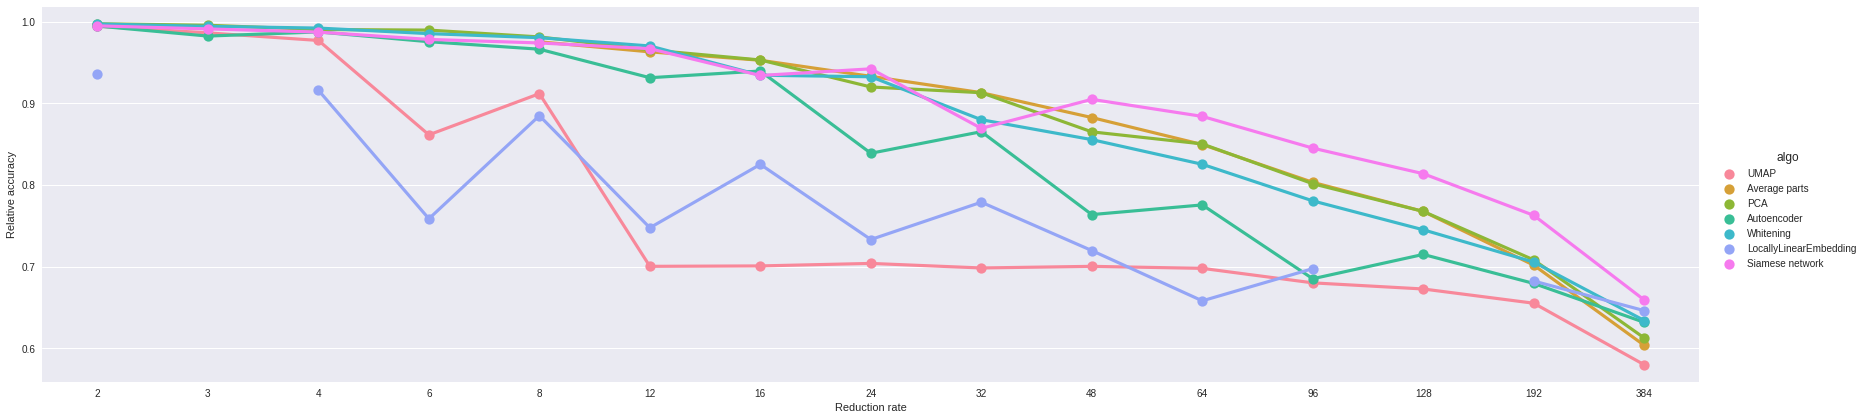

In [25]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
sns.catplot(data=bench_results_filtered.reset_index(), 
            x="reduction_rate", 
            y="percentage_acc", 
            hue="algo",
            kind="point",
            height=6, aspect=4,
            order=bench_results_filtered["reduction_rate"].unique()[::-1])
plt.ylabel("Relative accuracy")
plt.xlabel("Reduction rate");
plt.savefig("img/catplot.png");

Text(0.5, 0, 'Reduction rate')

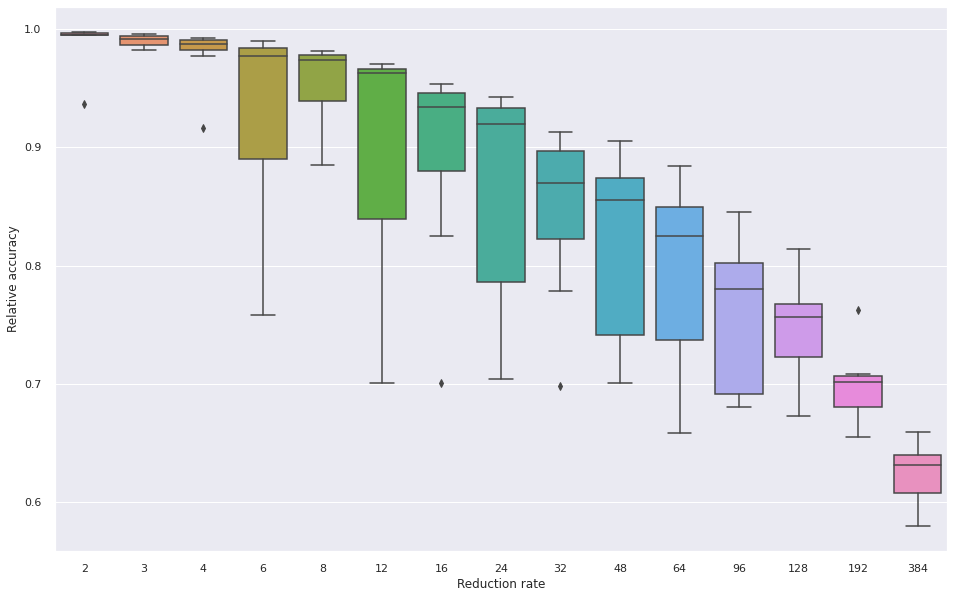

In [15]:
plt.figure(figsize=(16, 10))
sns.boxplot(data=bench_results_filtered.reset_index(), 
            x="reduction_rate", 
            y="percentage_acc")

plt.ylabel("Relative accuracy")
plt.xlabel("Reduction rate")

In [168]:
maxes = bench_results_filtered.reset_index().groupby("reduction_rate").max()['ratio']

bench_results_filtered[(bench_results_filtered["ratio"].isin(maxes)) & (~bench_results_filtered["algo"].isin(["Whitening", "Average parts"]))][["reduction_rate", "percentage_acc"]][::-1].T

method,PCA (64x32),PCA (384x128),PCA (768x128),PCA (768x96),PCA (64x4),Siamese network (768x32),Siamese network (768x16),Siamese network (768x12),Siamese network (768x8),Siamese network (768x6),Siamese network (768x4),Siamese network (768x2)
reduction_rate,2.0,3.0,6.0,8.0,16.0,24.0,48.0,64.0,96.0,128.0,192.0,384.0
percentage_acc,99.8,99.6,99.0,98.1,95.3,94.2,90.5,88.4,84.5,81.4,76.3,65.9


In [ ]:
bench_results_filtered.reset_index().groupby(["reduction_rate"]).max

In [17]:
algo_ranks = defaultdict(list)

for rate in bench_results_filtered["reduction_rate"].unique():
    bench_rate = bench_results_filtered[bench_results_filtered["reduction_rate"]==rate]
    
    ranks = bench_rate.set_index("algo").groupby("reduction_rate").rank(ascending=False)["ratio"].to_dict()
    for key in bench_results_filtered["algo"].unique():
        try:
            algo_ranks[key].append(int(ranks[key]))
        except KeyError:
            algo_ranks[key].append(pd.NA)
            
# del algo_ranks["CLS vector"]

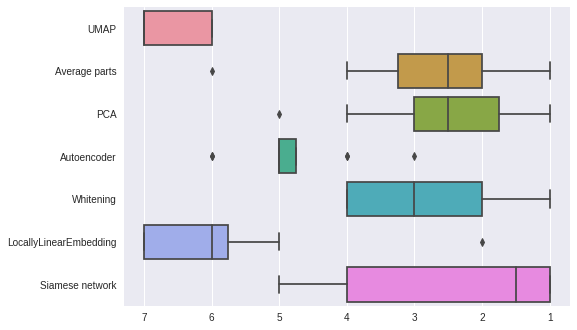

In [19]:
sns.boxplot(data=pd.DataFrame(algo_ranks).dropna(), orient='h')
plt.gca().invert_xaxis()
plt.savefig("img/ranks_boxplot.pdf")

In [234]:
pd.DataFrame(algo_ranks)

,Whitening,PCA,Average parts,Siamese network,CLS vector
0,4,3,2,1,<NA>
1,4,2,3,1,<NA>
2,2,3,4,1,<NA>
3,2,3,4,1,<NA>
4,2,3,4,1,<NA>
5,2,3,4,1,<NA>
6,3,2,1,4,<NA>
7,2,3,4,1,<NA>
8,3,2,1,4,<NA>
9,2,3,4,1,<NA>


In [171]:
# TODO: slope curve, but drawn in some other tool

## Create plots for final validation

In [218]:
def prepare_dframe(results):
    results["reduction rate"] = 768/results["Dimensions"]
    results["relative MAP"] = results["MAP"]/results.iloc[0]["MAP"]
    # results["relative index time"] = results["index_time_in_millis"]/results.iloc[0]["index_time_in_millis"]
    # results["relative storage"] = results["Storage [bytes]"]/results.iloc[0]["Storage [bytes]"]
    results["relative DCG"] = results["DCG mean"]/results.iloc[0]["DCG mean"]
    results["relative recall"] = results["Recall mean"]/results.iloc[0]["Recall mean"]
    # results["query speedup"] = results.iloc[0]["Total query time [s]"]/results["Total query time [s]"]
    return results

In [229]:
results_avg = pd.read_csv("models/biobert_avg_results.tsv", sep='\t')
results_avg = prepare_dframe(results_avg)

results_pca = pd.read_csv("models/pca_results.tsv", sep='\t')
results_pca = prepare_dframe(results_pca)

results_siamese= pd.read_csv("models/biobert_siamese_results.tsv", sep='\t')
results_siamese = prepare_dframe(results_siamese)

In [230]:
concat = pd.concat((results_avg, results_pca, results_siamese)).reset_index()[["relative MAP", "relative recall", 
                                                              "Algo", "reduction rate"]]

# sns.pairplot(concat, 
#              hue="Algo",
#              diag_kind="hist",
#             )

<AxesSubplot:xlabel='reduction rate', ylabel='query speedup'>

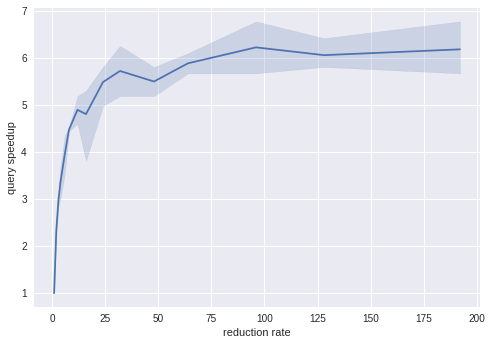

In [180]:
sns.lineplot(concat["reduction rate"], concat["query speedup"], markers=False)

In [228]:
concat[pca_pres_cond & avg_pres_cond & avg_cond]

,relative MAP,relative recall,Algo,reduction rate
1,0.910162,0.946186,Averaging,192.0
6,0.469471,0.544834,Averaging,24.0
7,0.381387,0.397707,Averaging,16.0
10,0.236688,0.150163,Averaging,4.0
11,0.215619,0.126034,Averaging,2.0


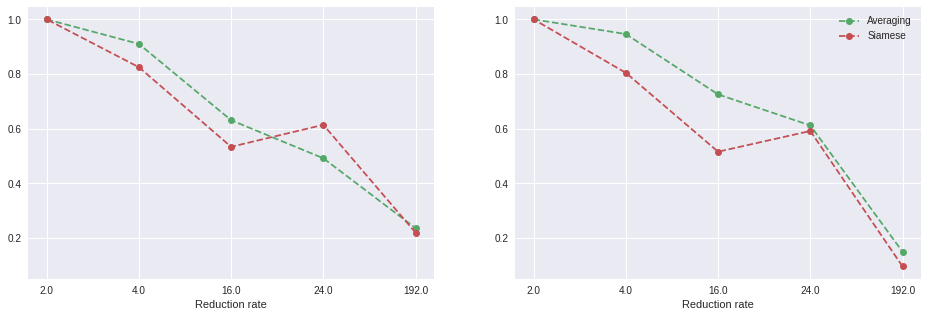

In [237]:
pca_pres_cond = concat["reduction rate"].isin(results_pca["reduction rate"])
avg_pres_cond = concat["reduction rate"].isin(results_avg["reduction rate"])
siam_pres_cond = concat["reduction rate"].isin(results_siamese["reduction rate"])

pca_cond = concat["Algo"]=="PCA"
avg_cond = concat["Algo"]=="Averaging"
siam_cond = concat["Algo"]=="Siamese"


# sns.catplot(data=concat[pca_cond & avg_cond], 
#             kind="point",
#             hue="Algo",
#             height=6, aspect=1.2,
#             x="reduction rate",
#             y="relative recall")
plt.figure(figsize=(16, 5))
plt.subplot(121)
# plt.plot(concat[pca_pres_cond & avg_pres_cond & pca_cond]["reduction rate"].astype(str),
#          concat[pca_pres_cond & avg_pres_cond & pca_cond]["relative MAP"], 'o--', label="PCA")
plt.gca()._get_lines.prop_cycler.__next__()

plt.plot(concat[pca_pres_cond & avg_pres_cond & avg_cond]["reduction rate"].astype(str),
         concat[pca_pres_cond & avg_pres_cond & avg_cond]["relative MAP"]/concat[pca_pres_cond & avg_pres_cond & avg_cond]["relative MAP"].max(), 'o--', label="Averaging")

plt.plot(concat[pca_pres_cond & avg_pres_cond & siam_cond]["reduction rate"].astype(str),
         concat[pca_pres_cond & avg_pres_cond & siam_cond]["relative MAP"]/concat[pca_pres_cond & avg_pres_cond & siam_cond]["relative MAP"].max(), 'o--', label="Siamese")
plt.xlabel("Reduction rate")

plt.subplot(122, sharey=plt.gca())
# plt.plot(concat[pca_pres_cond & avg_pres_cond & pca_cond]["reduction rate"].astype(str),
#          concat[pca_pres_cond & avg_pres_cond & pca_cond]["relative recall"], 'o--', label="PCA")
plt.gca()._get_lines.prop_cycler.__next__()

plt.plot(concat[pca_pres_cond & avg_pres_cond & avg_cond]["reduction rate"].astype(str),
         concat[pca_pres_cond & avg_pres_cond & avg_cond]["relative recall"]/concat[pca_pres_cond & avg_pres_cond & avg_cond]["relative recall"].max(), 'o--', label="Averaging")

plt.plot(concat[pca_pres_cond & avg_pres_cond & siam_cond]["reduction rate"].astype(str),
         concat[pca_pres_cond & avg_pres_cond & siam_cond]["relative recall"]/concat[pca_pres_cond & avg_pres_cond & siam_cond]["relative recall"].max(), 'o--', label="Siamese")

plt.xlabel("Reduction rate")
plt.legend()

plt.savefig("img/pubmed_metrics.pdf")

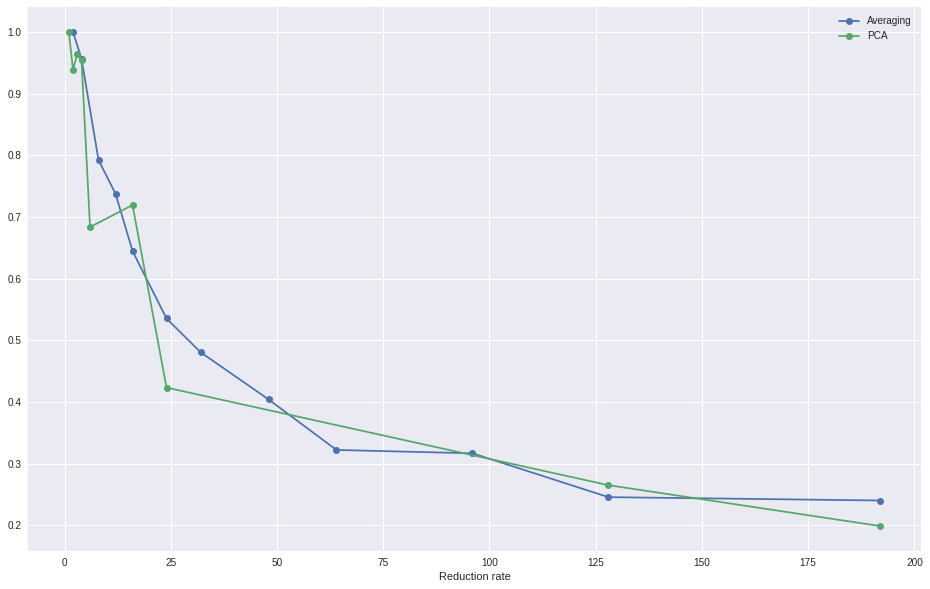

In [54]:
plt.figure(figsize=(16, 10))
plt.plot(results_avg["reduction_rate"], results_avg["relative MAP"], 'o-', label="Averaging")
plt.plot(results_pca["reduction_rate"], results_pca["relative MAP"], 'o-', label="PCA")
plt.legend()

plt.xlabel("Reduction rate")
plt.savefig("img/rate_vs_map.pdf")

In [201]:
results_siamese["storage reduction"] = (1/results_siamese["relative storage"]).apply(lambda x: round(x, 1))
results_siamese["Reduction"] = results_siamese["Reduction"].astype(int)

results_siamese[["Dimensions", "Reduction", "relative MAP", "relative recall", "query speedup", "storage reduction"]].set_index("Dimensions").iloc[8:].T

Dimensions,32,24,16,12,8,6,4
Reduction,24.000000,32.000000,48.000000,64.000000,96.000000,128.000000,192.000000
relative MAP,0.489796,0.392857,0.397959,0.290816,0.357143,0.316327,0.255102
relative recall,0.633452,0.389680,0.391459,0.343416,0.311388,0.286477,0.145907
query speedup,5.674419,6.256410,5.809524,6.100000,6.777778,6.421053,6.777778
storage reduction,5.800000,6.100000,6.500000,6.700000,7.000000,7.100000,7.200000


In [195]:
results_siamese

,Dimensions,Reduction,Total query time [s],Storage [bytes],index_time_in_millis,MAP,DCG mean,DCG std,Recall mean,Recall std,Algo,reduction rate,relative MAP,relative index time,relative storage,relative DCG,relative recall,query speedup,storage reduction
0,768,1,244,1133853641,151491,0.196,0.160,0.209,0.562,0.37,Siamese,1.0,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
1,384,2,101,647416401,54788,0.181,0.149,0.198,0.543,0.37,Siamese,2.0,0.923469,0.361658,0.570988,0.93125,0.966192,2.415842,1.751351
2,256,3,79,488412977,45929,0.170,0.141,0.192,0.502,0.38,Siamese,3.0,0.867347,0.303180,0.430755,0.88125,0.893238,3.088608,2.321506
3,192,4,66,401747425,30921,0.175,0.145,0.194,0.500,0.36,Siamese,4.0,0.892857,0.204111,0.354320,0.90625,0.889680,3.696970,2.822305
4,128,6,56,320674380,27556,0.148,0.124,0.185,0.464,0.37,Siamese,6.0,0.755102,0.181899,0.282818,0.77500,0.825623,4.357143,3.535841
5,96,8,54,280556808,32712,0.131,0.109,0.157,0.413,0.36,Siamese,8.0,0.668367,0.215934,0.247437,0.68125,0.734875,4.518519,4.041440
6,64,12,47,239313475,24233,0.130,0.108,0.163,0.419,0.37,Siamese,12.0,0.663265,0.159963,0.211062,0.67500,0.745552,5.191489,4.737943
7,48,16,46,217770374,31075,0.122,0.104,0.161,0.341,0.31,Siamese,16.0,0.622449,0.205128,0.192062,0.65000,0.606762,5.304348,5.206648
8,32,24,43,196731517,28344,0.096,0.084,0.137,0.356,0.34,Siamese,24.0,0.489796,0.187100,0.173507,0.52500,0.633452,5.674419,5.763457
9,24,32,39,185291517,21972,0.077,0.069,0.113,0.219,0.24,Siamese,32.0,0.392857,0.145038,0.163417,0.43125,0.389680,6.256410,6.119296
